# Read Text in images using EasyOCR

# Optical Character Recognition for Video Games

## Introduction

The goal of this project is to read the image of equipment in a video game called Maplestory and write down its description in an organized manner for better readability.


# Step-by-step Demo

Check the step-by-step demo for comments and explanations

## Setup
Install EasyOCR and import modules

In [ ]:
# install easyocr for image-text reading
%%capture
!pip install easyocr

In [ ]:
# Import the library
import easyocr

# Load the model
reader_en = easyocr.Reader(['en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% Complete

In [ ]:
import numpy as np
import pandas as pd
import cv2 as cv
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from PIL import Image
import matplotlib.pylab as plt

## Upload image and preprocess

The goal here is to preprocess the image to increase the OCR accuracy. These are some characteristics of typical equipement images for this project:

1. Size (HxW): 500-700 x 250-260 pixels
2. The equipement description follows a specific format.
3. The equipement description's characters are brighter than the background, but the background can be diffierent.

Knowing those, there are many ways to improve accuracy such as:

* Image Scaling.  
* Thresholding or Binarization.

There are some techniques I didn't use because they were'nt suitable for this situation. It is mainly because the input image is often has a little variance.

* Color filtering.
  * The HSV color filtering attampt didn't do well because it removed too many details.
* Noise Removal.
  * The image is often very clean since it's taken right from the video game via screenshot.
* Skew Correction.
  * The input image is always in the same orientation.
* Thinning and Skeletonization.
  * The description's font is too dense, so such process removed too many details.


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving example.png to example.png


In [ ]:
image_name = 'example.png'

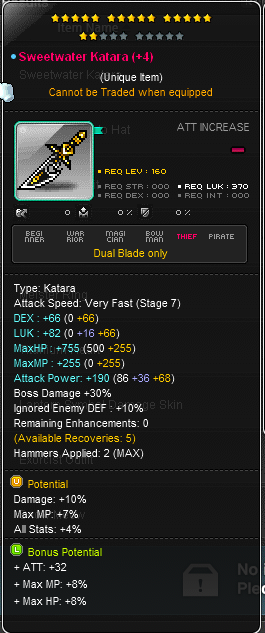

In [ ]:
image = cv.imread(image_name)
cv2_imshow(image)

The top 30% section of the image usually contains unimportant information, so crop it.

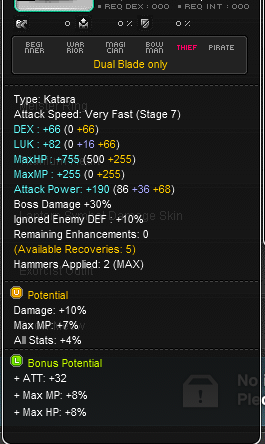

In [ ]:
height = image.shape[0]
height_to_remove = int(height * 0.3)
cropped_image = image[height_to_remove:,:]
cv2_imshow(cropped_image)

Enlarge the image for better readability for the OCR.

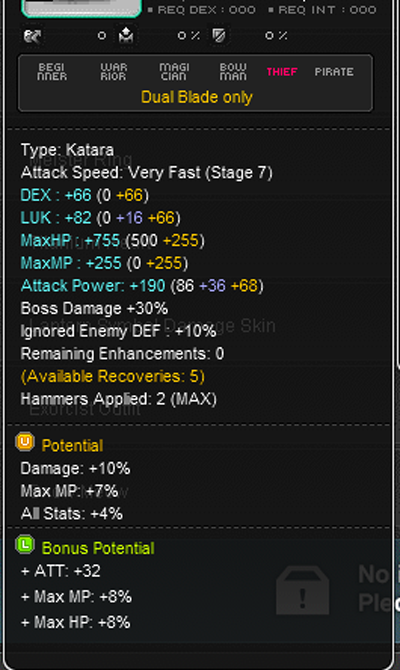

In [ ]:
height = cropped_image.shape[0]
width = cropped_image.shape[1]
desired_width = 400
size_factor = desired_width / width

enlarged = cv.resize(cropped_image, (0, 0), fx = size_factor, fy = size_factor, interpolation=cv.INTER_CUBIC)
cv2_imshow(enlarged)


Take advantage of the fact that the description font is brighter than the backgorund. Adjust the image contrast to isolate the description effectively.

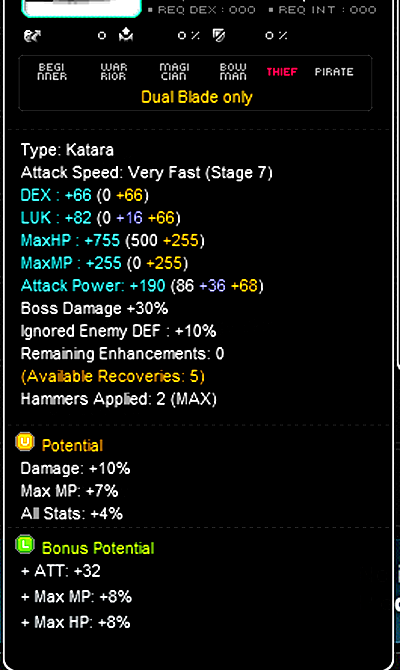

In [ ]:
# define the contrast and brightness value
contrast = 2 # Contrast control
brightness = -100 # Brightness control

contrasted = cv.addWeighted(enlarged, contrast, enlarged, 0, brightness)

cv2_imshow(contrasted)


## Read and process text

The biggest challenge in this section comes from the poor font of the equipement description. The little spacing between slim characters is the main problems. If slim characters are adjacent to each other, then they tend to cause confusion to the OCR.

Inaccurate OCR result examples:
1. 'INT' into 'NT'
2. 'Skill' into 'Ski'
3. 'Attack' into 'Aitack'
4. 'all' to 'ai'

To combat this problem, I took advantage of the equipement description format to extract the important information from the inaccurate OCR.

* Use the unique words that are consistently correct
(ex. represent 'Attack Power' using 'Power' instead of 'Attack')
* Use the unique words that are consistently incorrect but precise
(ex. 'INT' always turn into 'NT')





In [ ]:
text = reader_en.readtext(contrasted, detail = 0, width_ths = 5.0)
text

["REODEX:OOO 'REOINT:Ooo",
 'RGSR   XGR   Qaxi   Toax',
 'THIEF   PIRATE',
 'Dual Blade only',
 'Type: Katara',
 'Attack Speed: Very Fast (Stage 7)',
 'DEX : +66 (0 +66)',
 'LUK : +82 (0 +16 +66)',
 'MaxHP : +755 (500 +255)',
 'MaxMP : +255 (0 +255)',
 'Attack Power: +190 (86 +36 +68)',
 'Boss Damage +30%',
 'Ignored Enemy DEF : +10%',
 'Remainig Enhancements: 0',
 'Avalable Recoveries: 51',
 'Hammers Appled: 2 (MAX)',
 'Potential',
 'Damage: +10%',
 'Max MP: +7%',
 'AI Stats: +4%',
 'Bonus Potential',
 'ATT:+32',
 'Max MP +8%',
 'Max HP: +8%']

Get the region of interest. Remove the undesirable, non-stat-related words from the top of the image. Conveniently, the word 'type' is always the first word we want.

In [ ]:

index = 0
ROI = []

lowercase = [x.lower() for x in text]

for sentence in lowercase:
  first_word = sentence[0:4]
  if first_word == 'type':
    ROI = lowercase[index:]
    break
  index = index + 1

ROI

['type: katara',
 'attack speed: very fast (stage 7)',
 'dex : +66 (0 +66)',
 'luk : +82 (0 +16 +66)',
 'maxhp : +755 (500 +255)',
 'maxmp : +255 (0 +255)',
 'attack power: +190 (86 +36 +68)',
 'boss damage +30%',
 'ignored enemy def : +10%',
 'remainig enhancements: 0',
 'avalable recoveries: 51',
 'hammers appled: 2 (max)',
 'potential',
 'damage: +10%',
 'max mp: +7%',
 'ai stats: +4%',
 'bonus potential',
 'att:+32',
 'max mp +8%',
 'max hp: +8%']

What comes after brackets are always redundant details, so remove them

In [ ]:

remove_brackets = []

for sen in ROI:
  tempstr = ''
  for ch in sen:
    # what comes after brackets are always unimportant
    if ch =='(' or ch == '{' or ch == '[':
      break
    # In case the bracket is line-wrapped
    # and the line doesn't start with bracket, skip the entire line.
    elif  ch ==')' or ch == '}' or ch == ']':
      tempstr = ''
      break
    # otherwise, keep the characters
    tempstr = tempstr + ch

  if tempstr != '':
    remove_brackets.append(tempstr)

remove_brackets


['type: katara',
 'attack speed: very fast ',
 'dex : +66 ',
 'luk : +82 ',
 'maxhp : +755 ',
 'maxmp : +255 ',
 'attack power: +190 ',
 'boss damage +30%',
 'ignored enemy def : +10%',
 'remainig enhancements: 0',
 'avalable recoveries: 51',
 'hammers appled: 2 ',
 'potential',
 'damage: +10%',
 'max mp: +7%',
 'ai stats: +4%',
 'bonus potential',
 'att:+32',
 'max mp +8%',
 'max hp: +8%']

Now, clean up unnecessary characters

In [ ]:
import re

cleaned = []

for sen in remove_brackets:
  clean = re.sub('[;:,.\+\-]', ' ', sen)
  no_extra_spaces = ' '.join(clean.split())
  cleaned.append(no_extra_spaces)

cleaned

['type katara',
 'attack speed very fast',
 'dex 66',
 'luk 82',
 'maxhp 755',
 'maxmp 255',
 'attack power 190',
 'boss damage 30%',
 'ignored enemy def 10%',
 'remainig enhancements 0',
 'avalable recoveries 51',
 'hammers appled 2',
 'potential',
 'damage 10%',
 'max mp 7%',
 'ai stats 4%',
 'bonus potential',
 'att 32',
 'max mp 8%',
 'max hp 8%']

Create a list of features to keep track of. These are the feature that directly affect the strength of the equipment.

Also, the order of these keywords is crucial.
Since there are some stats that share certain keywords (eg. Damage, Boss Damage, and Critical Damage), more specific keyword must be checked before the generic one.

In [ ]:
keywords = ['str','dex', 'nt', 'luk', 'att', 'power', 'magic', 'maxmp', 'maxhp',
            'boss', 'cal', 'damage', 'enemy', 'stats', 'sec']

# this will contain a list of stats to add later (flat integar or integar with %)
keydict = {k: [] for k in keywords}

keydict

{'str': [],
 'dex': [],
 'nt': [],
 'luk': [],
 'att': [],
 'power': [],
 'magic': [],
 'maxmp': [],
 'maxhp': [],
 'boss': [],
 'cal': [],
 'damage': [],
 'enemy': [],
 'stats': [],
 'sec': []}

Put the lines of description into the corresponding key in the dictionary.

In [ ]:

stop_check_sentence = False

# check each line of stat
for sen in cleaned:

  # split the line into words for better recognition
  words = sen.split(' ')
  for word in words:

    # go through keywords to find match the lines
    for keyword in keywords:

      # critical damage is difficult to detect because it's not unique.
      # 'critical' is unreliable, and 'damange' is too general.
      # Therefore, when dealing with critical damage, use 'in' instead of '=='
      if keyword == 'cal':

        if keyword in word:

          number = words[1:]
          keydict[keyword].append(number)

          stop_check_sentence = True
          break;

      else:

        if keyword == word:

          number = words[1:]
          keydict[keyword].append(number)

          stop_check_sentence = True
          break;

    if stop_check_sentence:
      stop_check_sentence = False
      break

keydict

{'str': [],
 'dex': [['66']],
 'nt': [],
 'luk': [['82']],
 'att': [['32']],
 'power': [['power', '190']],
 'magic': [],
 'maxmp': [['255']],
 'maxhp': [['755']],
 'boss': [['damage', '30%']],
 'cal': [],
 'damage': [['10%']],
 'enemy': [['enemy', 'def', '10%']],
 'stats': [['stats', '4%']],
 'sec': []}

In [ ]:
# att and power points to the same stat. Combine them.

keydict['att'] = keydict['att'] + keydict['power']
del keydict['power']

keywords.remove('power')

keydict

{'str': [],
 'dex': [['66']],
 'nt': [],
 'luk': [['82']],
 'att': [['32'], ['power', '190']],
 'magic': [],
 'maxmp': [['255']],
 'maxhp': [['755']],
 'boss': [['damage', '30%']],
 'cal': [],
 'damage': [['10%']],
 'enemy': [['enemy', 'def', '10%']],
 'stats': [['stats', '4%']],
 'sec': []}

Now, read each line of descrption in each key, classify them into three categories [[flat numbers], [%s], [and per-levels]], and combine like-data.







In [ ]:

keydict_new = {k: [0,0,0] for k in keywords}

for key in keywords:
  for stat_line in keydict[key]:
    # The last element in the line is always the number.
    last_char = stat_line[-1][-1]
    number = stat_line[-1]

    # if the number has %, then it goes to percent
    if last_char == '%':
      keydict_new[key][1] += int(number[:-1])

    # cooldown seconds
    elif last_char == 'c':
      keydict_new[key][0] += int(stat_line[-2])

    # this is '1 or 2 stat per level' line.
    elif stat_line[0] == 'per':
      keydict_new[key][2] += int(number)

    #flat number otherwise
    else:
      keydict_new[key][0] += int(number)

keydict_new

{'str': [0, 0, 0],
 'dex': [66, 0, 0],
 'nt': [0, 0, 0],
 'luk': [82, 0, 0],
 'att': [222, 0, 0],
 'magic': [0, 0, 0],
 'maxmp': [255, 0, 0],
 'maxhp': [755, 0, 0],
 'boss': [0, 30, 0],
 'cal': [0, 0, 0],
 'damage': [0, 10, 0],
 'enemy': [0, 10, 0],
 'stats': [0, 4, 0],
 'sec': [0, 0, 0]}

Time to print the result.

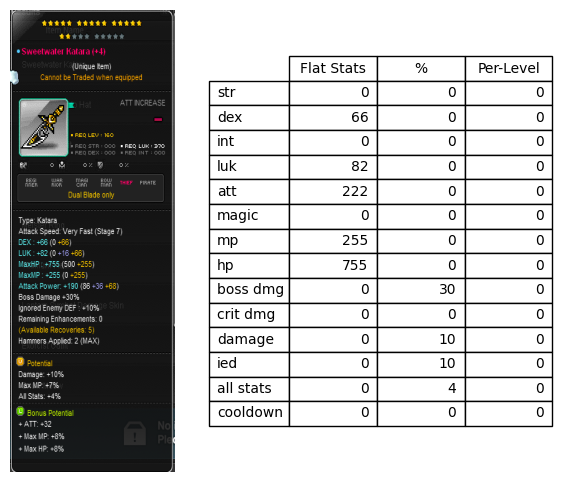

In [ ]:
import pandas as pd


df = pd.DataFrame.from_dict(keydict_new)

df.rename(columns={'nt': 'int', 'maxmp': 'mp', 'maxhp': 'hp',
                   'boss': 'boss dmg', 'cal': 'crit dmg',
                   'enemy': 'ied', 'stats': 'all stats', 'sec':'cooldown'},
          index={0:'Flat Stats',1:'%',2:'Per-Level'}, inplace=True)

df = df.T

dpi = 100
figsize = int(image.shape[1]*3 / float(dpi)), int(image.shape[0]/ float(dpi))

fig, (a1, a2) = plt.subplots(1, 2, figsize=figsize,  width_ratios=[1, 2])
a1.imshow( cv.cvtColor(image, cv.COLOR_BGR2RGB))
a1.axis('off')
a1.axis('tight')
table = a2.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0.2, 0.1, 0.8, 0.8])
a2.axis('off')
a2.axis('tight')
plt.show()


# All-in-one Demo

Check this demo if you just want to test it.

In [1]:
%%capture
!pip install easyocr
import easyocr
reader_en = easyocr.Reader(['en'])

import numpy as np
import pandas as pd
import cv2 as cv
from google.colab.patches import cv2_imshow
from skimage import io
from PIL import Image
import matplotlib.pylab as plt
import re
import matplotlib.pyplot as plt
import pandas as pd
from google.colab import files

In [12]:
def read_equipement_description(image_name):

  uploaded = files.upload()
  image = cv.imread(image_name)

  height = image.shape[0]
  height_to_remove = int(height * 0.3)
  cropped_image = image[height_to_remove:,:]

  height = cropped_image.shape[0]
  width = cropped_image.shape[1]
  desired_width = 400
  size_factor = desired_width / width
  enlarged = cv.resize(cropped_image, (0, 0), fx = size_factor, fy = size_factor, interpolation=cv.INTER_CUBIC)

  contrast = 2
  brightness = -100
  contrasted = cv.addWeighted(enlarged, contrast, enlarged, 0, brightness)

  text = reader_en.readtext(contrasted, detail = 0, width_ths = 5.0)

  index = 0
  ROI = []

  lowercase = [x.lower() for x in text]

  for sentence in lowercase:
    first_word = sentence[0:4]
    if first_word == 'type':
      ROI = lowercase[index:]
      break
    index = index + 1

  remove_brackets = []

  for sen in ROI:
    tempstr = ''
    for ch in sen:
      if ch =='(' or ch == '{' or ch == '[':
        break
      elif  ch ==')' or ch == '}' or ch == ']':
        tempstr = ''
        break
      tempstr = tempstr + ch

    if tempstr != '':
      remove_brackets.append(tempstr)

  cleaned = []

  for sen in remove_brackets:
    clean = re.sub('[;:,.\+\-]', ' ', sen)
    no_extra_spaces = ' '.join(clean.split())
    cleaned.append(no_extra_spaces)

  keywords = ['str','dex', 'nt', 'luk', 'att', 'power', 'magic', 'maxmp', 'maxhp',
              'boss', 'cal', 'damage', 'enemy', 'stats', 'sec']
  keydict = {k: [] for k in keywords}
  stop_check_sentence = False

  for sen in cleaned:
    words = sen.split(' ')
    for word in words:
      for keyword in keywords:
        if keyword == 'cal':
          if keyword in word:
            number = words[1:]
            keydict[keyword].append(number)
            stop_check_sentence = True
            break;
        else:
          if keyword == word:
            number = words[1:]
            keydict[keyword].append(number)
            stop_check_sentence = True
            break;
      if stop_check_sentence:
        stop_check_sentence = False
        break

  keydict['att'] = keydict['att'] + keydict['power']
  del keydict['power']

  keywords.remove('power')

  keydict_new = {k: [0,0,0] for k in keywords}

  for key in keywords:
    for stat_line in keydict[key]:
      last_char = stat_line[-1][-1]
      number = stat_line[-1]
      if last_char == '%':
        keydict_new[key][1] += int(number[:-1])
      elif last_char == 'c':
        keydict_new[key][0] += int(stat_line[-2])
      elif stat_line[0] == 'per':
        keydict_new[key][2] += int(number)
      else:
        keydict_new[key][0] += int(number)

  df = pd.DataFrame.from_dict(keydict_new)

  df.rename(columns={'nt': 'int', 'maxmp': 'mp', 'maxhp': 'hp',
                    'boss': 'boss dmg', 'cal': 'crit dmg',
                    'enemy': 'ied', 'stats': 'all stats', 'sec':'cooldown'},
            index={0:'Flat Stats',1:'%',2:'Per-Level'}, inplace=True)
  df = df.T

  dpi = 100
  figsize = int(image.shape[1]*3 / float(dpi)), int(image.shape[0]/ float(dpi))

  fig, (a1, a2) = plt.subplots(1, 2, figsize=figsize,  width_ratios=[1, 2])
  a1.imshow( cv.cvtColor(image, cv.COLOR_BGR2RGB))
  a1.axis('off')
  a1.axis('tight')
  table = a2.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center', bbox=[0.2, 0.1, 0.8, 0.8])
  a2.axis('off')
  a2.axis('tight')
  plt.show()


Example 1: Armor type equipment with cooldown reduction. It works well.

Saving cool.png to cool.png


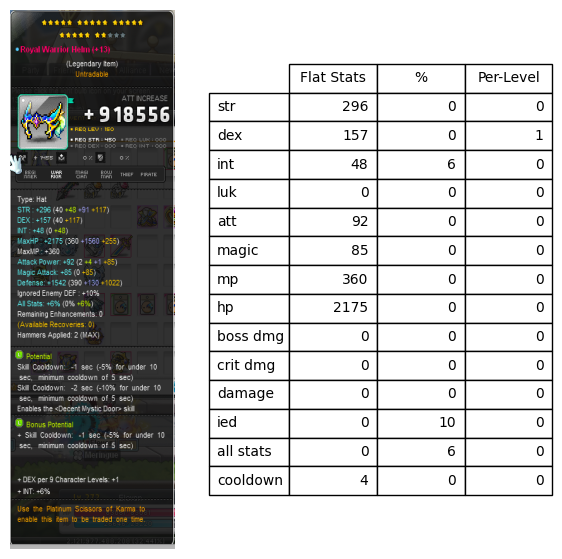

In [13]:
read_equipement_description('cool.png')

Example 2: Weapon type equipment with various lines. It works, except that 'DEX' is not detected because the cursor is blocking the word.

Saving weap.png to weap.png


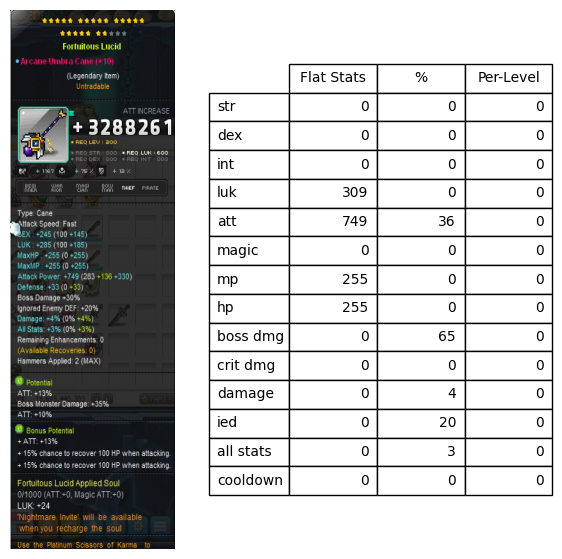

In [ ]:
read_equipement_description('weap.png')

Example 3: Armor type equipment with critical damage. It works well even when the background is darker than previous examples.

Saving crit.png to crit.png


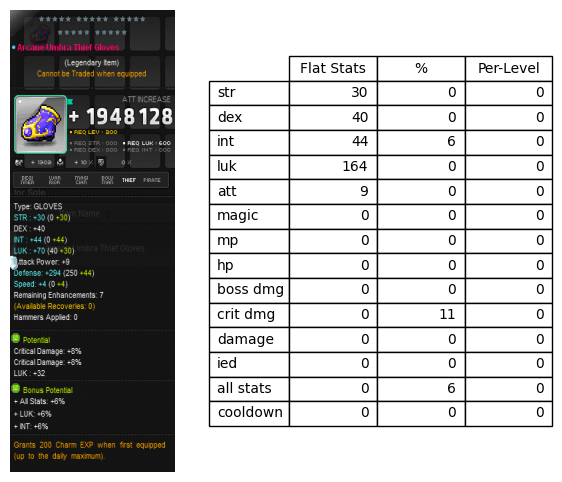

In [ ]:
read_equipement_description('crit.png')

Example 4: Secondary weapon type equipment with a lot fewer lines than armor and weapon. It works well.

Saving sec.png to sec.png


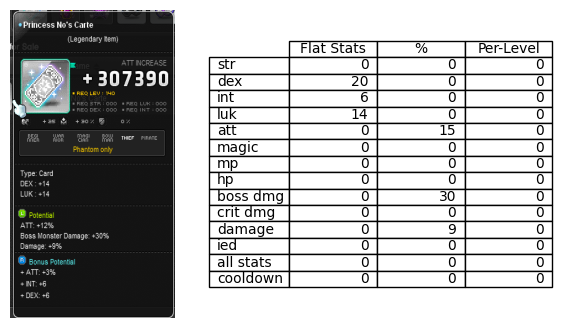

In [ ]:
read_equipement_description('sec.png')

# Discussion

##Challenges:

1.Low text detection accuracy:

The biggest challenge in this section came from the poor font of the equipement description. The little spacing between slim characters is the main problem. If slim characters are adjacent to each other, then they tend to cause confusion to the OCR.

Inaccurate OCR result examples:
1. 'INT' into 'NT'
2. 'Skill' into 'Ski'
3. 'Attack' into 'Aitack'
4. 'all' to 'ai'
5. 'Power:' to 'Power.'

This is the inherent limit of the input and I must work around it.

2.Slow text detection.

The entire process takes around 14 seconds. This is too slow. The most time (10+ seconds) is taken in the EasyOCR's text detection step. A faster model or solution is needed.


##Potential solution:

EasyOCR is easy to work with since it's ready to use off the shelf. However, it is not too robust in terms of the types of font it can detect.

To solve this issue, I can make a new OCR model using YOLOv8. YOLO is a fast and accurate object detection model. I think I can train the model to recognize the unique traits of Maplestory's font. I can also train it to recognize the region of interest - where the important descriptions are located - so there is less post-processing to do to get the final result.

An example of training data might look like the image below. The large, beige-colored box is the region of interest where the important descriptions are. The rest of the smaller boxes are the important descriptions.

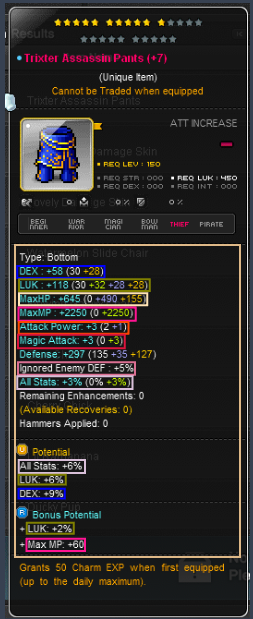

In [ ]:
cv2_imshow(yolo_example_image)